In [2]:
import pandas as pd
import numpy as np
import random

# File operations
from copy import deepcopy
import glob
import os
from pathlib import Path

# AHBA
import abagen

# Neuromaps
import neuromaps
from neuromaps.parcellate import Parcellater
from neuromaps import datasets, images, nulls, resampling, stats
from nibabel import freesurfer as fs
import nibabel as nib
from neuromaps.datasets import fetch_annotation, fetch_fslr
from enigmatoolbox.datasets import load_sc, load_fc

# Stats
from scipy.stats import spearmanr, wilcoxon, mannwhitneyu
import statsmodels.stats.multitest

# Set seed to 127
random.seed(127)

%load_ext rpy2.ipython

In [3]:
%%R 

suppressPackageStartupMessages({
    library(cowplot)
    library(ggseg)
    library(glue)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

In [5]:
data_path = "/Users/abry4213/data/HCP100/"

# Read in brain region lookup table
brain_region_info = pd.read_csv("../data/Brain_Region_Info.csv")

# Load in pyspi SPI info 
pyspi_info = pd.read_csv("../functional_connectivity_analysis/pyspi_SPI_info.csv")

#### GROUP-AVERAGED FUNCTIONAL CONNECTOME FROM ENIGMA #### 
# Load cortico-cortical functional connectivity data
fc_ctx, fc_ctx_labels, _, _ = load_fc(parcellation='aparc')

# Load cortico-cortical functional connectivity data
fc_ctx, fc_ctx_labels, fc_subctx_to_ctx, fc_subctx_labels = load_fc(parcellation='aparc')

# Read in preprocessed Pearson-based functional connectivity data from ENIGMA
HCP_avg_Pearson_FC = (pd.DataFrame(fc_ctx, columns=fc_ctx_labels)
                      .assign(Brain_Region_From = fc_ctx_labels)
                      .melt(id_vars=["Brain_Region_From"], 
                             var_name="Brain_Region_To", 
                             value_name="Mean_Pearson_R")
                      .assign(Base_Region_From = lambda x: x['Brain_Region_From'].str.replace("L_", "").str.replace("R_", ""),
                              Base_Region_To = lambda x: x['Brain_Region_To'].str.replace("L_", "").str.replace("R_", ""),
                              Hemi_From = lambda x: np.where(x['Brain_Region_From'].str.startswith("L_"), "Left", "Right"),
                              Hemi_To = lambda x: np.where(x['Brain_Region_To'].str.startswith("L_"), "Left", "Right"))
)

pearson_homotopic_res_mean = (HCP_avg_Pearson_FC
                              .query("Base_Region_From == Base_Region_To")
                              .groupby(["Base_Region_From"])['Mean_Pearson_R']
                              .mean() 
                              .reset_index()
                              .rename(columns={"Base_Region_From": "Cortical_Region"})
                              )

subctx_to_ctx_FC = (pd.DataFrame(fc_subctx_to_ctx, columns=fc_ctx_labels)
                          .assign(Brain_Region_From = fc_subctx_labels)
                          .melt(id_vars=["Brain_Region_From"],
                            var_name="Brain_Region_To", 
                            value_name="Mean_Pearson_R")
                            .assign(Hemisphere_From = lambda x: x["Brain_Region_From"].str[0].map({"L": "Left", "R": "Right"}),
                              Hemisphere_To = lambda x: x["Brain_Region_To"].str[0].map({"L": "Left", "R": "Right"}))
                            .assign(Base_Region_From = lambda x: x["Brain_Region_From"].str[1:],
                                    Base_Region_To = lambda x: x.Brain_Region_To.str.replace("L_", "").str.replace("R_", ""))
                            [['Base_Region_From', 'Base_Region_To', 'Mean_Pearson_R']]
                            .rename(columns={"Mean_Pearson_R": "FC_with_subctx",
                                             "Base_Region_From": "Subcortical_Region",
                                             "Base_Region_To": "Cortical_Region"})
                     # Remove first letter from the region names

)

subctx_to_ctx_FC.head()


,Subcortical_Region,Cortical_Region,FC_with_subctx
0,accumb,bankssts,0.016861
1,amyg,bankssts,0.103434
2,caud,bankssts,0.115149
3,hippo,bankssts,0.158356
4,pal,bankssts,0.033192


In [4]:

HoFC_with_subctx_connectivity = (pearson_homotopic_res_mean
    .rename(columns={"Base_Region": "Cortical_Region",
                     "Mean_Pearson_R": "HoFC"})
    .merge(subctx_to_ctx_FC, on="Cortical_Region")
    .groupby(['Cortical_Region', 'Subcortical_Region'])[['HoFC', 'FC_with_subctx']]
    .mean()
    .reset_index()
)

HoFC_with_subctx_connectivity.head()

,Cortical_Region,Subcortical_Region,HoFC,FC_with_subctx
0,bankssts,accumb,0.31467,0.016905
1,bankssts,amyg,0.31467,0.098062
2,bankssts,caud,0.31467,0.103207
3,bankssts,hippo,0.31467,0.152820
4,bankssts,pal,0.31467,0.034594


In [6]:
# Load CTIP2 and Satb2 gene expression data if available
if os.path.isfile('../data/Pyramidal_neuron_CTIP2_Satb2_expression_ctx.csv'):
    pyramidal_neuron_key_gene_expression_ctx = pd.read_csv('../data/Pyramidal_neuron_CTIP2_Satb2_expression_ctx.csv')

    if 'base_region' in pyramidal_neuron_key_gene_expression_ctx.columns: 
        pyramidal_neuron_key_gene_expression_ctx = pyramidal_neuron_key_gene_expression_ctx.rename(columns={'base_region': "Cortical_Region"})

else:
    abagen.fetch_microarray(donors='all', verbose=1)

    atlas = abagen.fetch_desikan_killiany()
    atlas_info = pd.read_csv(atlas['info'])
    expression = abagen.get_expression_data(atlas['image'], atlas['info'])

    CTIP2_expression = expression['BCL11B']
    Satb2_expression = expression['SATB2']

    pyramidal_neuron_key_gene_expression_ctx = (pd.DataFrame({'CTIP2': CTIP2_expression.values, 
                                                              'Satb2': Satb2_expression.values, 
                                                'region': atlas_info.label, 'hemisphere': atlas_info.hemisphere,
                                                'structure': atlas_info.structure})
                                                .query("structure=='cortex'")
                                                .groupby(['region', 'hemisphere'])[['CTIP2', 'Satb2']]
                                                .mean()
                                                .reset_index()
                                                .rename(columns={'region': 'Cortical_Region'})
    )

    # Write to csv
    pyramidal_neuron_key_gene_expression_ctx.to_csv('../data/Pyramidal_neuron_CTIP2_Satb2_expression_ctx.csv', index=False)

# Take the mean between the left and right hemisphere
pyramidal_neuron_key_gene_expression_ctx_base = (pyramidal_neuron_key_gene_expression_ctx
                                                 .groupby(['Cortical_Region'])[['CTIP2', 'Satb2']]
                                                    .mean()
                                                    .reset_index()
)

gene_HoFC_merged = pearson_homotopic_res_mean.merge(pyramidal_neuron_key_gene_expression_ctx_base, on="Cortical_Region")

CTIP2_rho, CTIP2_p = spearmanr(gene_HoFC_merged['Mean_Pearson_R'], gene_HoFC_merged['CTIP2'])
Satb2_rho, Satb2_p = spearmanr(gene_HoFC_merged['Mean_Pearson_R'], gene_HoFC_merged['Satb2'])

print(f"CTIP2: rho={CTIP2_rho:.2f}, p={CTIP2_p:.2e}")
print(f"Satb2: rho={Satb2_rho:.2f}, p={Satb2_p:.2e}")


/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/abagen/probes_.py:147: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  return io.read_microarray(microarray).groupby(sid, axis=1).mean()
/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/abagen/probes_.py:147: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  return io.read_microarray(microarray).groupby(sid, axis=1).mean()
/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/abagen/probes_.py:147: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  return io.read_microarray(microarray).groupby(sid, axis=1).mean()
/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/abagen/probes_.py:147: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis i

CTIP2: rho=-0.28, p=1.13e-01
Satb2: rho=0.49, p=2.95e-03


/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/abagen/samples_.py:404: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gene_by_label = pd.concat([
/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/abagen/samples_.py:481: FutureWarning: The provided callable <function mean at 0x1182be3a0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  microarray = pd.concat(microarray).groupby('label').aggregate(metric)


In [ ]:
%%R -i pyramidal_neuron_key_gene_expression_ctx_base,pearson_homotopic_res_mean

legendwidth <- 2

Pearson_HoFC_brain <- pearson_homotopic_res_mean %>%
  ungroup() %>%
  mutate(label = glue("lh_{base_region}")) %>%
  left_join(., as_tibble(dk)) %>%
  ggseg(atlas = dk, mapping = aes(fill = Mean_Pearson_R),
        position = "stacked", colour = "black", hemisphere="left",
        linewidth=0.25) +
  theme_void() +
  labs(fill = "Mean Pearson R") +
  guides(fill = guide_colorbar(title.position="top", title.hjust=0.5)) +
  theme(plot.title = element_text(face='bold', size=14, hjust=0.5),
            legend.key.width  = unit(legendwidth, "lines"),
            legend.key.height  = unit(0.7, "lines"),
            legend.position = "bottom") +
  scale_fill_viridis_c(na.value = "white")

CTIP2_brain <- pyramidal_neuron_key_gene_expression_ctx_base %>%
      mutate(label = glue("lh_{base_region}")) %>%
      left_join(., as_tibble(dk)) %>%
      filter(hemi=='left') %>%
      ggplot() +
      geom_brain(atlas = dk, mapping = aes(fill = CTIP2),
                 hemi = "left", color='black') +
      theme_void() +
      labs(fill = "Expression (a.u.)") +
      guides(fill = guide_colorbar(title.position="top", title.hjust=0.5)) +
      theme(plot.title = element_text(face='bold', size=14, hjust=0.5),
            legend.key.width  = unit(legendwidth, "lines"),
            legend.key.height  = unit(0.7, "lines"),
            legend.position = "bottom") +
      scale_fill_gradient(low="white", high="#67913c", na.value = "white")

Satb2_brain <- pyramidal_neuron_key_gene_expression_ctx_base %>%
      mutate(label = glue("lh_{base_region}")) %>%
      left_join(., as_tibble(dk)) %>%
      filter(hemi=='left') %>%
      ggplot() +
      geom_brain(atlas = dk, mapping = aes(fill = Satb2),
                 hemi = "left", color='black') +
      theme_void() +
      labs(fill = "Expression (a.u.)") +
      guides(fill = guide_colorbar(title.position="top", title.hjust=0.5)) +
      theme(plot.title = element_text(face='bold', size=14, hjust=0.5),
            legend.key.width  = unit(legendwidth, "lines"),
            legend.key.height  = unit(0.7, "lines"),
            legend.position = "bottom") +
      scale_fill_gradientn(
            colours = c("white", "white", "#a864d2"),
            values = scales::rescale(c(0.55, 0.72, 0.825)),
            limits = c(0.55, 0.825),
            na.value = "white"
            )

wrap_plots(list(Pearson_HoFC_brain, CTIP2_brain, Satb2_brain), ncol=1)
# ggsave("../plots/neuromaps_corrs/Layer5_Neuron_Gene_Expression_brainmaps.svg", width=4, height=6, units='in', dpi=300)

In [ ]:
%%R -i gene_HoFC_merged

# CTIP2 scatter plot
CTIP2_scatter <- gene_HoFC_merged %>% 
      ggplot(data=., mapping=aes(x=CTIP2, y=Mean_Pearson_R, fill=CTIP2)) +
      geom_point(shape=21, color='black', size=3, alpha=0.8) +
      ggpubr::stat_cor(method="spearman", cor.coef.name="rho", size=5, aes(label = ..r.label..)) +
      theme(legend.position='none') +
      geom_smooth(method='lm', se=FALSE, color='black') +
      scale_fill_gradient(low="white", high="#67913c") +
      theme(strip.background = element_blank(),
            strip.text = element_text(face='bold', size=16),
            axis.text = element_text(size=15))

# Satb2 scatter plot
Satb2_scatter <- gene_HoFC_merged %>%
      ggplot(data=., mapping=aes(x=Satb2, y=Mean_Pearson_R, fill=Satb2)) +
      geom_point(shape=21, color='black', size=3, alpha=0.8) +
      ggpubr::stat_cor(method="spearman", cor.coef.name="rho", size=5, aes(label = ..r.label..)) +
      theme(legend.position='none') +
      geom_smooth(method='lm', se=FALSE, color='black') +
            scale_fill_gradientn(
            colours = c("white", "white", "#a864d2"),
            values = scales::rescale(c(0.55, 0.72, 0.825)),
            limits = c(0.55, 0.825),
            na.value = "white"
            ) +
      theme(strip.background = element_blank(),
            strip.text = element_text(face='bold', size=16),
            axis.text = element_text(size=15))

wrap_plots(list(CTIP2_scatter, Satb2_scatter), ncol=1)
# ggsave("../plots/neuromaps_corrs/Layer5_Neuron_Gene_Expression_scatters.svg", width=3, height=6, units='in', dpi=300)

In [24]:
# Define the left- and right-hemisphere Desikan-Killiany (DK) atlas
lh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/lh.aparc.annot"
rh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/rh.aparc.annot"

# Convert the DK atlas to gifti format
# dk_gifti = neuromaps.images.annot_to_gifti((lh_dk, rh_dk), background=None)
dk_gifti = neuromaps.images.annot_to_gifti(lh_dk, background=None)
dk_gifti = neuromaps.images.relabel_gifti(dk_gifti)

# Fit a Parcellator object
dk_parc = Parcellater(dk_gifti, 'fsLR', resampling_target='parcellation', hemi='L')

# Satb2 first
rng = np.random.default_rng(seed=127)  # for reproducibility
Satb2_measure = gene_HoFC_merged['Satb2'].values
HoFC_measure = gene_HoFC_merged['Mean_Pearson_R'].values

# Assume you are working with fsaverage and the Desikan-Killiany atlas
atlas = 'fsLR'

# Use DEF to generate the nulls
spins = nulls.alexander_bloch(Satb2_measure, atlas=atlas, parcellation=dk_gifti, density='164k',
                              n_perm=10000, seed=127)

# Step 4: Compare ABC and DEF using the nulls
stat, p = stats.compare_images(HoFC_measure, Satb2_measure, nulls=spins, metric='spearmanr')

print(f"Observed correlation: {stat:.3f}")
print(f"P-value (spin test): {p:.4f}")

Observed correlation: 0.495
P-value (spin test): 0.0018


## HoFC vs thalamic connectivity

`geom_smooth()` using formula = 'y ~ x'



ℹ Please use `after_stat(r.label)` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 

ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 

ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 



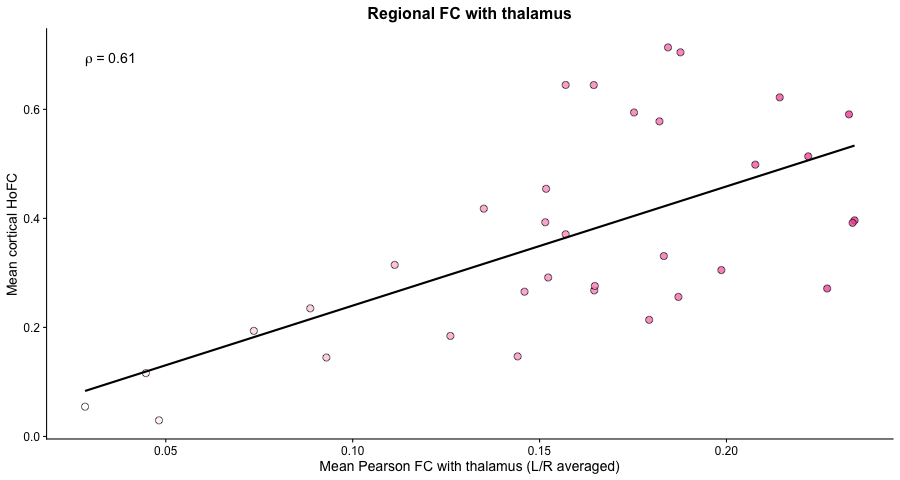

In [14]:
%%R -i HoFC_with_subctx_connectivity -w 900

HoFC_with_subctx_connectivity %>% 
    filter(Subcortical_Region == "thal") %>%
    ggplot(data=., mapping=aes(x=FC_with_subctx, y=HoFC, fill=FC_with_subctx)) +
    geom_point(shape=21, color='black', size=3, alpha=0.8) +
    ggtitle("Regional FC with thalamus") +
    geom_smooth(method="lm", se=FALSE, color='black') +
    ggpubr::stat_cor(method="spearman", cor.coef.name="rho", size=5, aes(label = ..r.label..)) +
    theme(legend.position='none')+
    ylab("Mean cortical HoFC") +
    scale_fill_gradient(low='white', high='#f357a7') +
    xlab("Mean Pearson FC with thalamus (L/R averaged)") +
    theme(strip.background = element_blank(),
          strip.text = element_text(face='bold', size=14),
          plot.title = element_text(hjust=0.5, face='bold', size=16))

# ggsave("../plots/neuromaps_corrs/Thalamus_FC_vs_HoFC_scatters.svg", width=3, height=3.25, units='in', dpi=300)

Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi', 'geometry'


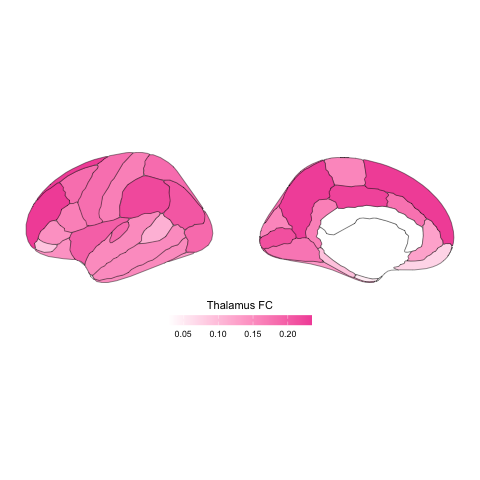

In [15]:
%%R -i HoFC_with_subctx_connectivity

legendwidth <- 2

HoFC_with_subctx_connectivity %>%
      filter(Subcortical_Region=='thal') %>%
      mutate(label = glue("lh_{Cortical_Region}")) %>%
      left_join(., as_tibble(dk)) %>%
      filter(hemi=='left') %>%
      ggplot() +
      geom_brain(atlas = dk, mapping = aes(fill = FC_with_subctx),
                 hemi = "left", color='black') +
      theme_void() +
      labs(fill = "Thalamus FC") +
      guides(fill = guide_colorbar(title.position="top", title.hjust=0.5)) +
      theme(plot.title = element_text(face='bold', size=14, hjust=0.5),
            legend.key.width  = unit(legendwidth, "lines"),
            legend.key.height  = unit(0.7, "lines"),
            legend.position = "bottom") +
      scale_fill_gradient(low='white', high='#f357a7', na.value = "white")
# ggsave("../plots/neuromaps_corrs/Thalamus_FC_vs_HoFC_brain.svg", width=4, height=3, units='in', dpi=300)

In [22]:
HoFC_with_thal_connectivity = HoFC_with_subctx_connectivity.query("Subcortical_Region=='thal'")
HoFC_with_thal_connectivity.head()

,Cortical_Region,Subcortical_Region,HoFC,FC_with_subctx
6,bankssts,thal,0.314670,0.111235
13,caudalanteriorcingulate,thal,0.213912,0.179315
20,caudalmiddlefrontal,thal,0.330858,0.183238
27,cuneus,thal,0.644840,0.156975
34,entorhinal,thal,0.029524,0.048178


In [25]:
# Spin test
rng = np.random.default_rng(seed=127)  # for reproducibility
thal_FC_measure = HoFC_with_thal_connectivity['FC_with_subctx'].values
HoFC_measure = HoFC_with_thal_connectivity['HoFC'].values

# Assume you are working with fsaverage and the Desikan-Killiany atlas
atlas = 'fsLR'

# Use DEF to generate the nulls
spins = nulls.alexander_bloch(thal_FC_measure, atlas=atlas, parcellation=dk_gifti, density='164k',
                              n_perm=10000, seed=127)

# Step 4: Compare ABC and DEF using the nulls
stat, p = stats.compare_images(HoFC_measure, thal_FC_measure, nulls=spins, metric='spearmanr')

print(f"Observed correlation: {stat:.3f}")
print(f"P-value (spin test): {p:.4f}")

Observed correlation: 0.608
P-value (spin test): 0.0007


## Plot core--matrix thalamus gradient

In [16]:
gene_HoFC_merged.head()

,Cortical_Region,Mean_Pearson_R,CTIP2,Satb2,PVALB,CALB
0,bankssts,0.314670,0.500093,0.789470,0.688432,0.453611
1,caudalanteriorcingulate,0.213912,0.691314,0.723061,0.446511,0.520241
2,caudalmiddlefrontal,0.330858,0.648525,0.783846,0.773508,0.406171
3,cuneus,0.644840,0.465227,0.796707,0.765939,0.432270
4,entorhinal,0.029524,0.635760,0.591633,0.195500,0.443272


Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi', 'geometry'


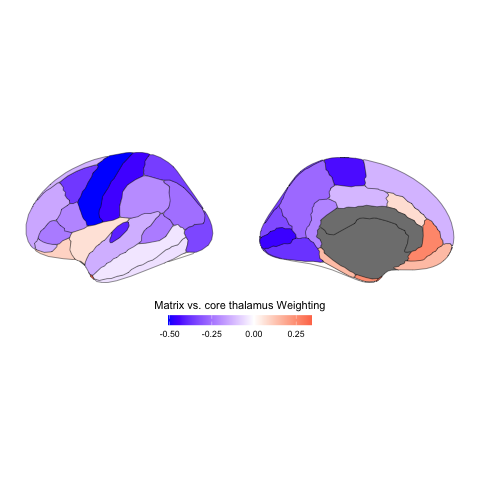

In [19]:
%%R -i gene_HoFC_merged

legendwidth <- 2

gene_HoFC_merged %>%
      mutate(Matrix_Core_Gradient = CALB - PVALB, label = glue("lh_{Cortical_Region}")) %>%
      left_join(., as_tibble(dk)) %>%
      filter(hemi=='left') %>%
      ggplot() +
      geom_brain(atlas = dk, mapping = aes(fill = Matrix_Core_Gradient),
                 hemi = "left", color='black') +
      theme_void() +
      labs(fill = "Matrix vs. core thalamus Weighting") +
      scale_fill_gradient2(low='blue', mid='white', high='red', midpoint=0) +
      guides(fill = guide_colorbar(title.position="top", title.hjust=0.5)) +
      theme(plot.title = element_text(face='bold', size=14, hjust=0.5),
            legend.key.width  = unit(legendwidth, "lines"),
            legend.key.height  = unit(0.7, "lines"),
            legend.position = "bottom")